In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -----------------------------
# User settings
# -----------------------------
RELAX_GRIDS = 10   # Number of grid points in relaxation zone
DEFAULT_GEO_EM = "geo_em.d01.nc"
OUTPUT_FIG = "wrf_domain.png"

# -----------------------------
# Function: Convert longitude 0–360 → −180–180
# -----------------------------
def lon_360_to_180(lon):
    return (lon + 180) % 360 - 180

# -----------------------------
# Reference points for domains
# -----------------------------
DOMAIN_POINTS = {
    "SAM": {
        "TLC": (273.26, 18.50), "CNB": (300.56, 15.40), "TRC": (327.52, 17.23),
        "CWB": (265.88, -17.30), "CPD": (299.70, -21.11), "CEB": (333.36, -18.84),
        "BLC": (254.28, -52.66), "CSB": (298.13, -57.61), "BRC": (343.02, -54.60)
    },
    "AFR": {
        "TLC": (335.36, 42.24), "CNB": (17.60, 42.24), "TRC": (60.28, 42.24),
        "CWB": (335.36, -1.32), "CPD": (17.60, -1.32), "CEB": (60.28, -1.32),
        "BLC": (335.36, -45.76), "CSB": (17.60, -45.76), "BRC": (60.28, -45.76)
    },
    "WAS": {
        "TLC": (19.88, 43.5), "CNB": (68.41, 45.07), "TRC": (115.55, 41.0),
        "CWB": (23.48, 15.51), "CPD": (67.18, 16.93), "CEB": (110.47, 13.09),
        "BLC": (26.19, -12.97), "CSB": (66.29, -11.66), "BRC": (106.43, -15.23)
    }
}

# -----------------------------
# Function: Plot WRF domain
# -----------------------------
def plot_wrf_domain(domain_name, geo_em_file=None):
    if domain_name not in DOMAIN_POINTS:
        raise ValueError(f"Domain {domain_name} not recognized. Choose from {list(DOMAIN_POINTS.keys())}")
    
    geo_em_file = geo_em_file or DEFAULT_GEO_EM
    
    # Read geo_em
    ds = xr.open_dataset(geo_em_file)
    lons = lon_360_to_180(ds["XLONG_M"][0, :, :].values)
    lats = ds["XLAT_M"][0, :, :].values
    ny, nx = lons.shape
    
    if RELAX_GRIDS >= min(nx, ny) // 2:
        raise ValueError("Relaxation zone too large for domain size")
    
    # Domain boundaries
    lon_s, lat_s = lons[0, :], lats[0, :]
    lon_n, lat_n = lons[-1, :], lats[-1, :]
    lon_w, lat_w = lons[:, 0], lats[:, 0]
    lon_e, lat_e = lons[:, -1], lats[:, -1]
    
    # Relaxation zone
    k = RELAX_GRIDS
    lon_s_r, lat_s_r = lons[k, :], lats[k, :]
    lon_n_r, lat_n_r = lons[-k-1, :], lats[-k-1, :]
    lon_w_r, lat_w_r = lons[:, k], lats[:, k]
    lon_e_r, lat_e_r = lons[:, -k-1], lats[:, -k-1]
    
    # Reference points
    puntos = {name: (lon_360_to_180(lon), lat) for name, (lon, lat) in DOMAIN_POINTS[domain_name].items()}
    
    # Plot
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Background
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="aliceblue")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    
    # Outer boundary
    for lon, lat in [(lon_s, lat_s), (lon_n, lat_n), (lon_w, lat_w), (lon_e, lat_e)]:
        ax.plot(lon, lat, "r", lw=2, label="Domain boundary" if lon is lon_s else "")
    
    # Relaxation zone
    for lon, lat in [(lon_s_r, lat_s_r), (lon_n_r, lat_n_r), (lon_w_r, lat_w_r), (lon_e_r, lat_e_r)]:
        ax.plot(lon, lat, "r--", lw=1.8, label="Relaxation zone (10 grids)" if lon is lon_s_r else "")
    
    # Reference points
    for name, (lon, lat) in puntos.items():
        ax.plot(lon, lat, "kx", ms=5)
        ax.text(lon + 0.5, lat + 0.5, name, fontsize=9)
    
    ax.set_extent([lons.min()-10, lons.max()+10, lats.min()-10, lats.max()+10], crs=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True)
    ax.legend(loc="lower left")
    plt.title(f"WRF {domain_name} Domain with {RELAX_GRIDS}-Grid Relaxation Zone")
    plt.tight_layout()
    
    # Save figure
    output_file = f"wrf_domain_{domain_name}.png"
    plt.savefig(output_file, dpi=300)
    plt.show()
    print(f"Figure saved as {output_file}")

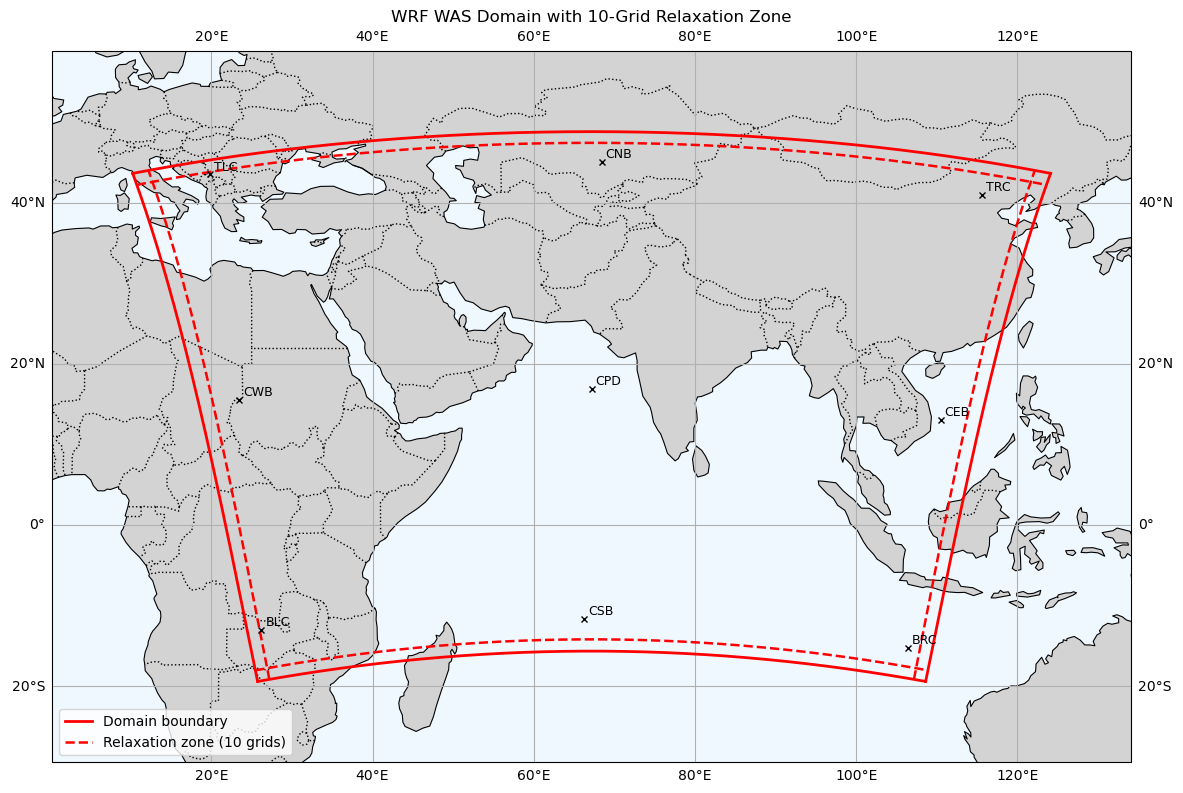

Figure saved as wrf_domain_WAS.png


In [5]:
plot_wrf_domain("WAS")  

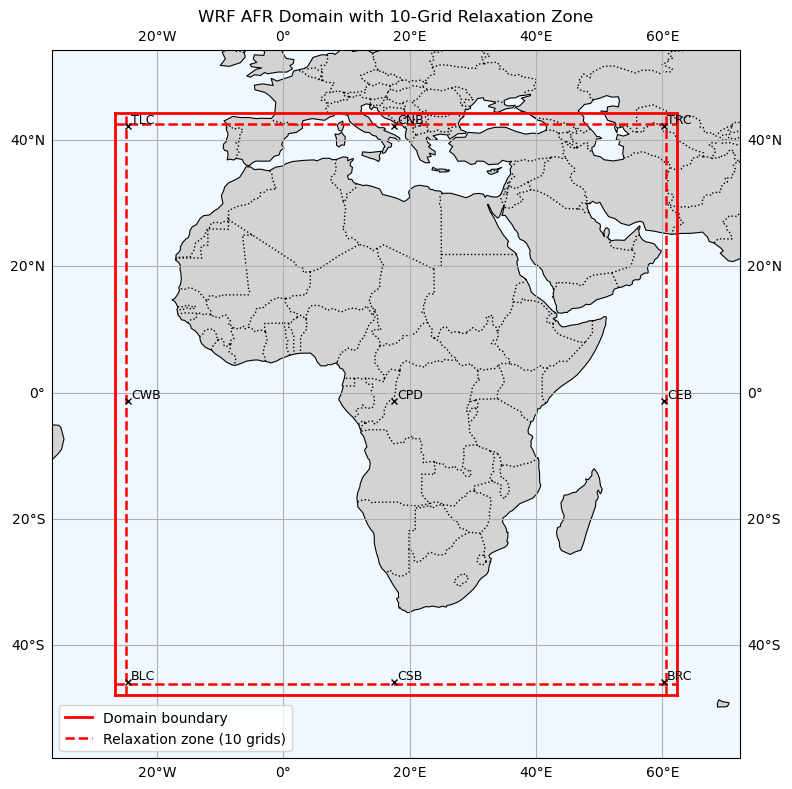

Figure saved as wrf_domain_AFR.png


In [6]:
plot_wrf_domain("AFR", "geo_em.d01_AFR-18.nc")